In [2]:
# Transformers installation
! pip install transformers datasets
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git

# Object detection

Object detection is the computer vision task of detecting instances (such as humans, buildings, or cars) in an image. Object detection models receive an image as input and output
coordinates of the bounding boxes and associated labels of the detected objects. An image can contain multiple objects,
each with its own bounding box and a label (e.g. it can have a car and a building), and each object can
be present in different parts of an image (e.g. the image can have several cars).
This task is commonly used in autonomous driving for detecting things like pedestrians, road signs, and traffic lights.
Other applications include counting objects in images, image search, and more.

In this guide, you will learn how to:

 1. Finetune [DETR](https://huggingface.co/docs/transformers/model_doc/detr), a model that combines a convolutional
 backbone with an encoder-decoder Transformer, on the [CPPE-5](https://huggingface.co/datasets/cppe-5)
 dataset.
 2. Use your finetuned model for inference.

<Tip>
The task illustrated in this tutorial is supported by the following model architectures:

<!--This tip is automatically generated by `make fix-copies`, do not fill manually!-->

[Conditional DETR](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/conditional_detr), [Deformable DETR](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/deformable_detr), [DETA](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/deta), [DETR](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/detr), [Table Transformer](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/table-transformer), [YOLOS](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/yolos)

<!--End of the generated tip-->

</Tip>

Before you begin, make sure you have all the necessary libraries installed:

```bash
pip install -q datasets transformers evaluate timm albumentations
```

You'll use 🤗 Datasets to load a dataset from the Hugging Face Hub, 🤗 Transformers to train your model,
and `albumentations` to augment the data. `timm` is currently required to load a convolutional backbone for the DETR model.

We encourage you to share your model with the community. Log in to your Hugging Face account to upload it to the Hub.
When prompted, enter your token to log in:

In [3]:
from huggingface_hub import notebook_login

notebook_login()

## Load the CPPE-5 dataset

The [CPPE-5 dataset](https://huggingface.co/datasets/cppe-5) contains images with
annotations identifying medical personal protective equipment (PPE) in the context of the COVID-19 pandemic.

Start by loading the dataset:

In [44]:
from datasets import load_dataset

cppe5 = load_dataset("cppe-5")
cppe5

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 29
    })
})

You'll see that this dataset already comes with a training set containing 1000 images and a test set with 29 images.

To get familiar with the data, explore what the examples look like.

In [45]:
cppe5["train"][0]

{'image_id': 15,
 'image': <PIL.Image.Image image mode=RGB size=943x663>,
 'width': 943,
 'height': 663,
 'objects': {'id': [114, 115, 116, 117],
  'area': [3796, 1596, 152768, 81002],
  'bbox': [[302.0, 109.0, 73.0, 52.0],
   [810.0, 100.0, 57.0, 28.0],
   [160.0, 31.0, 248.0, 616.0],
   [741.0, 68.0, 202.0, 401.0]],
  'category': [4, 4, 0, 0]}}

The examples in the dataset have the following fields:
- `image_id`: the example image id
- `image`: a `PIL.Image.Image` object containing the image
- `width`: width of the image
- `height`: height of the image
- `objects`: a dictionary containing bounding box metadata for the objects in the image:
  - `id`: the annotation id
  - `area`: the area of the bounding box
  - `bbox`: the object's bounding box (in the [COCO format](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/#coco) )
  - `category`: the object's category, with possible values including `Coverall (0)`, `Face_Shield (1)`, `Gloves (2)`, `Goggles (3)` and `Mask (4)`

You may notice that the `bbox` field follows the COCO format, which is the format that the DETR model expects.
However, the grouping of the fields inside `objects` differs from the annotation format DETR requires. You will
need to apply some preprocessing transformations before using this data for training.

To get an even better understanding of the data, visualize an example in the dataset.

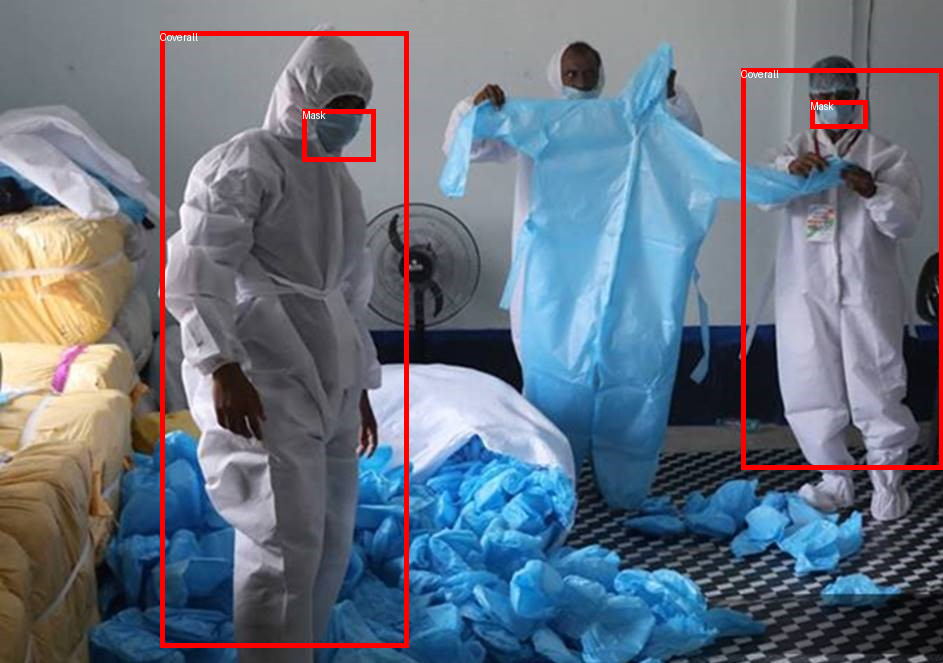

In [46]:
import numpy as np
import os
from PIL import Image, ImageDraw

image = cppe5["train"][0]["image"]
annotations = cppe5["train"][0]["objects"]
draw = ImageDraw.Draw(image)

categories = cppe5["train"].features["objects"].feature["category"].names

id2label = {index: x for index, x in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}

for i in range(len(annotations["id"])):
    box = annotations["bbox"][i - 1]
    class_idx = annotations["category"][i - 1]
    x, y, w, h = tuple(box)
    draw.rectangle((x, y, x + w, y + h), outline="red", width=5)
    draw.text((x, y), id2label[class_idx], fill="white")

image

<div class="flex justify-center">
    <img src="https://i.imgur.com/TdaqPJO.png" alt="CPPE-5 Image Example"/>
</div>

To visualize the bounding boxes with associated labels, you can get the labels from the dataset's metadata, specifically
the `category` field.
You'll also want to create dictionaries that map a label id to a label class (`id2label`) and the other way around (`label2id`).
You can use them later when setting up the model. Including these maps will make your model reusable by others if you share
it on the Hugging Face Hub.

As a final step of getting familiar with the data, explore it for potential issues. One common problem with datasets for
object detection is bounding boxes that "stretch" beyond the edge of the image. Such "runaway" bounding boxes can raise
errors during training and should be addressed at this stage. There are a few examples with this issue in this dataset.
To keep things simple in this guide, we remove these images from the data.

In [12]:
remove_idx = [590, 821, 822, 875, 876, 878, 879]
keep = [i for i in range(len(cppe5["train"])) if i not in remove_idx]
cppe5["train"] = cppe5["train"].select(keep)

In [62]:
cppe5

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 29
    })
})

In [49]:
cppe5_iter = iter(cppe5["train"])

In [54]:
img=next(cppe5_iter)

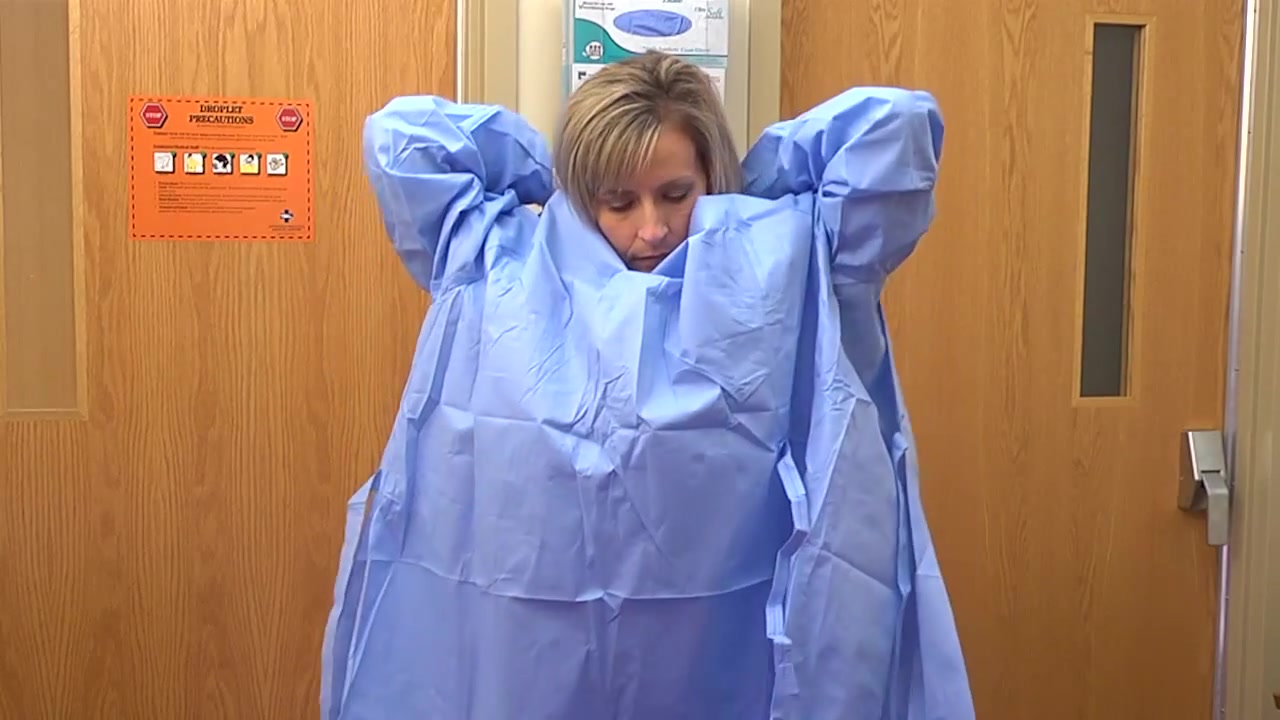

In [55]:
#img
img['image']

## Preprocess the data

To finetune a model, you must preprocess the data you plan to use to match precisely the approach used for the pre-trained model.
[AutoImageProcessor](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoImageProcessor) takes care of processing image data to create `pixel_values`, `pixel_mask`, and
`labels` that a DETR model can train with. The image processor has some attributes that you won't have to worry about:

- `image_mean = [0.485, 0.456, 0.406 ]`
- `image_std = [0.229, 0.224, 0.225]`

These are the mean and standard deviation used to normalize images during the model pre-training. These values are crucial
to replicate when doing inference or finetuning a pre-trained image model.

Instantiate the image processor from the same checkpoint as the model you want to finetune.

In [24]:
from transformers import AutoImageProcessor

checkpoint = "facebook/detr-resnet-50"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

Before passing the images to the `image_processor`, apply two preprocessing transformations to the dataset:
- Augmenting images
- Reformatting annotations to meet DETR expectations

First, to make sure the model does not overfit on the training data, you can apply image augmentation with any data augmentation library. Here we use [Albumentations](https://albumentations.ai/docs/) ...
This library ensures that transformations affect the image and update the bounding boxes accordingly.
The 🤗 Datasets library documentation has a detailed [guide on how to augment images for object detection](https://huggingface.co/docs/datasets/object_detection),
and it uses the exact same dataset as an example. Apply the same approach here, resize each image to (480, 480),
flip it horizontally, and brighten it:

In [25]:
import albumentations
import numpy as np
import torch

transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [87]:

examples = cppe5['train'].take(3)# CGM
#print(examples)
print('\n')
print(type(examples.features))
print(examples.features)
#print(examples.features.get('image_id'))
#print(examples.features.get('image'))
#print(examples.features.get('width'))
#print(examples.features.get('height'))

print(type(examples.features.get('objects')))
print(examples.features.get('objects'))

print('\n')
#img['image']
img = examples[0]
img



<class 'datasets.features.features.Features'>
{'image_id': Value(dtype='int64', id=None), 'image': Image(mode=None, decode=True, id=None), 'width': Value(dtype='int32', id=None), 'height': Value(dtype='int32', id=None), 'objects': Sequence(feature={'id': Value(dtype='int64', id=None), 'area': Value(dtype='int64', id=None), 'bbox': Sequence(feature=Value(dtype='float32', id=None), length=4, id=None), 'category': ClassLabel(names=['Coverall', 'Face_Shield', 'Gloves', 'Goggles', 'Mask'], id=None)}, length=-1, id=None)}
<class 'datasets.features.features.Sequence'>
Sequence(feature={'id': Value(dtype='int64', id=None), 'area': Value(dtype='int64', id=None), 'bbox': Sequence(feature=Value(dtype='float32', id=None), length=4, id=None), 'category': ClassLabel(names=['Coverall', 'Face_Shield', 'Gloves', 'Goggles', 'Mask'], id=None)}, length=-1, id=None)




{'image_id': 15,
 'image': <PIL.Image.Image image mode=RGB size=943x663>,
 'width': 943,
 'height': 663,
 'objects': {'id': [114, 115, 116, 117],
  'area': [3796, 1596, 152768, 81002],
  'bbox': [[302.0, 109.0, 73.0, 52.0],
   [810.0, 100.0, 57.0, 28.0],
   [160.0, 31.0, 248.0, 616.0],
   [741.0, 68.0, 202.0, 401.0]],
  'category': [4, 4, 0, 0]}}

<PIL.Image.Image image mode=RGB size=943x663 at 0x7EF39801CD00>
{'id': [114, 115, 116, 117], 'area': [3796, 1596, 152768, 81002], 'bbox': [[302.0, 109.0, 73.0, 52.0], [810.0, 100.0, 57.0, 28.0], [160.0, 31.0, 248.0, 616.0], [741.0, 68.0, 202.0, 401.0]], 'category': [4, 4, 0, 0]}
[[302.0, 109.0, 73.0, 52.0], [810.0, 100.0, 57.0, 28.0], [160.0, 31.0, 248.0, 616.0], [741.0, 68.0, 202.0, 401.0]]
[4, 4, 0, 0]




array([[[133, 131, 130],
        [133, 131, 130],
        [133, 131, 130],
        ...,
        [152, 145, 138],
        [152, 145, 138],
        [152, 145, 138]],

       [[133, 131, 130],
        [133, 131, 130],
        [133, 131, 130],
        ...,
        [151, 144, 136],
        [151, 144, 136],
        [151, 144, 136]],

       [[133, 131, 130],
        [133, 131, 130],
        [133, 131, 130],
        ...,
        [150, 143, 135],
        [150, 143, 135],
        [150, 143, 135]],

       ...,

       [[ 55,  49,  48],
        [ 58,  52,  51],
        [ 52,  47,  46],
        ...,
        [ 45,  77,  93],
        [ 48,  82,  99],
        [ 52,  84, 104]],

       [[ 47,  41,  40],
        [ 45,  39,  38],
        [ 47,  41,  40],
        ...,
        [ 48,  80,  97],
        [ 50,  84, 101],
        [ 53,  87, 105]],

       [[ 71,  66,  65],
        [ 50,  46,  45],
        [ 45,  40,  39],
        ...,
        [ 51,  83, 100],
        [ 51,  86, 102],
        [ 53,  87, 105]]], dtype=uint8)
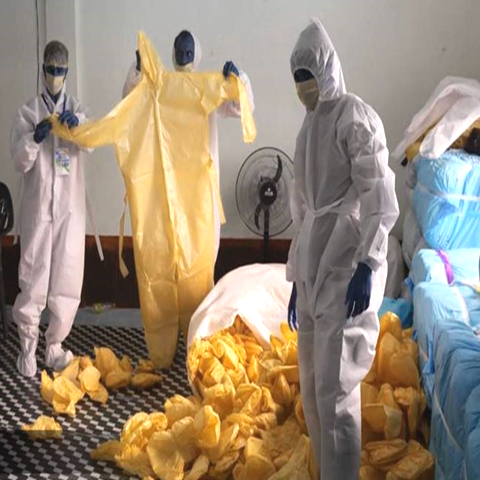

[[289.1198425292969, 78.91403198242188, 37.15800857543945, 37.647056579589844], [38.685035705566406, 72.398193359375, 29.013805389404297, 20.27149200439453], [272.3223876953125, 22.443439483642578, 126.23541259765625, 445.97283935546875], [0.0, 49.230770111083984, 102.82078552246094, 290.3167419433594]]
[4.0, 4.0, 0.0, 0.0]


In [99]:
# CGM
#examples = [img]

for image, objects in zip(examples["image"], examples["objects"]):
  print(image)
  print(objects)
  print(objects["bbox"])
  print(objects["category"])
  print('\n')
  image = np.array(image.convert("RGB"))[:, :, ::-1]
  #image = np.array(image.convert("RGB"))[:, :, ::]
  #display(image)
  out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])
  #print(out)

  display(out["image"])
  print(out["bboxes"])
  print(out["category"])
  break

The `image_processor` expects the annotations to be in the following format: `{'image_id': int, 'annotations': List[Dict]}`,
 where each dictionary is a COCO object annotation. Let's add a function to reformat annotations for a single example:

In [27]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

Now you can combine the image and annotation transformations to use on a batch of examples:

In [28]:
# transforming a batch
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

Apply this preprocessing function to the entire dataset using 🤗 Datasets [with_transform](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.with_transform) method. This method applies
transformations on the fly when you load an element of the dataset.

At this point, you can check what an example from the dataset looks like after the transformations. You should see a tensor
with `pixel_values`, a tensor with `pixel_mask`, and `labels`.

In [29]:
cppe5["train"] = cppe5["train"].with_transform(transform_aug_ann)
cppe5["train"][15]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


{'pixel_values': tensor([[[ 1.1872,  1.1872,  1.1872,  ..., -1.3987, -1.3987, -1.3987],
          [ 1.1872,  1.1872,  1.1872,  ..., -1.3987, -1.3987, -1.3987],
          [ 1.1872,  1.1872,  1.1872,  ..., -1.3815, -1.3815, -1.3815],
          ...,
          [-1.0390, -1.0390, -1.0390,  ..., -1.4158, -1.4158, -1.4158],
          [-1.0219, -1.0219, -1.0219,  ..., -1.4158, -1.3987, -1.3987],
          [-1.0219, -1.0219, -1.0219,  ..., -1.4158, -1.3987, -1.3987]],
 
         [[ 1.5882,  1.5882,  1.5882,  ..., -1.2654, -1.2654, -1.2654],
          [ 1.5882,  1.5882,  1.5882,  ..., -1.2654, -1.2654, -1.2654],
          [ 1.5882,  1.5882,  1.5882,  ..., -1.2479, -1.2479, -1.2479],
          ...,
          [-0.7752, -0.7752, -0.7752,  ..., -1.2829, -1.2829, -1.2829],
          [-0.7577, -0.7577, -0.7577,  ..., -1.2829, -1.2654, -1.2654],
          [-0.7577, -0.7577, -0.7577,  ..., -1.2829, -1.2654, -1.2654]],
 
         [[ 1.6988,  1.6988,  1.6988,  ..., -1.0550, -1.0550, -1.0550],
          [ 

You have successfully augmented the individual images and prepared their annotations. However, preprocessing isn't
complete yet. In the final step, create a custom `collate_fn` to batch images together.
Pad images (which are now `pixel_values`) to the largest image in a batch, and create a corresponding `pixel_mask`
to indicate which pixels are real (1) and which are padding (0).

In [38]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    #encoding = image_processor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

## Training the DETR model

You have done most of the heavy lifting in the previous sections, so now you are ready to train your model!
The images in this dataset are still quite large, even after resizing. This means that finetuning this model will
require at least one GPU.

Training involves the following steps:
1. Load the model with [AutoModelForObjectDetection](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoModelForObjectDetection) using the same checkpoint as in the preprocessing.
2. Define your training hyperparameters in [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments).
3. Pass the training arguments to [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) along with the model, dataset, image processor, and data collator.
4. Call [train()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train) to finetune your model.

When loading the model from the same checkpoint that you used for the preprocessing, remember to pass the `label2id`
and `id2label` maps that you created earlier from the dataset's metadata. Additionally, we specify `ignore_mismatched_sizes=True` to replace the existing classification head with a new one.

In [39]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In the [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments) use `output_dir` to specify where to save your model, then configure hyperparameters as you see fit.
It is important you do not remove unused columns because this will drop the image column. Without the image column, you
can't create `pixel_values`. For this reason, set `remove_unused_columns` to `False`.
If you wish to share your model by pushing to the Hub, set `push_to_hub` to `True` (you must be signed in to Hugging
Face to upload your model).

In [40]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="detr-resnet-50_finetuned_cppe5",
    per_device_train_batch_size=8,
    num_train_epochs=10,
    fp16=True,
    save_steps=200,
    logging_steps=50,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    #push_to_hub=True,  # CGM
    push_to_hub=False,
)

Finally, bring everything together, and call [train()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train):

In [41]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=cppe5["train"],
    tokenizer=image_processor,
)

#trainer.train()

<ipython-input-41-5350bd300a06>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [42]:
trainer.train()

Step,Training Loss


KeyboardInterrupt: 

If you have set `push_to_hub` to `True` in the `training_args`, the training checkpoints are pushed to the
Hugging Face Hub. Upon training completion, push the final model to the Hub as well by calling the [push_to_hub()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.push_to_hub) method.

In [ ]:
trainer.push_to_hub()

## Evaluate

Object detection models are commonly evaluated with a set of <a href="https://cocodataset.org/#detection-eval">COCO-style metrics</a>.
You can use one of the existing metrics implementations, but here you'll use the one from `torchvision` to evaluate the final
model that you pushed to the Hub.

To use the `torchvision` evaluator, you'll need to prepare a ground truth COCO dataset. The API to build a COCO dataset
requires the data to be stored in a certain format, so you'll need to save images and annotations to disk first. Just like
when you prepared your data for training, the annotations from the `cppe5["test"]` need to be formatted. However, images
should stay as they are.

The evaluation step requires a bit of work, but it can be split in three major steps.
First, prepare the `cppe5["test"]` set: format the annotations and save the data to disk.

In [ ]:
import json


# format annotations the same as for training, no need for data augmentation
def val_formatted_anns(image_id, objects):
    annotations = []
    for i in range(0, len(objects["id"])):
        new_ann = {
            "id": objects["id"][i],
            "category_id": objects["category"][i],
            "iscrowd": 0,
            "image_id": image_id,
            "area": objects["area"][i],
            "bbox": objects["bbox"][i],
        }
        annotations.append(new_ann)

    return annotations


# Save images and annotations into the files torchvision.datasets.CocoDetection expects
def save_cppe5_annotation_file_images(cppe5):
    output_json = {}
    path_output_cppe5 = f"{os.getcwd()}/cppe5/"

    if not os.path.exists(path_output_cppe5):
        os.makedirs(path_output_cppe5)

    path_anno = os.path.join(path_output_cppe5, "cppe5_ann.json")
    categories_json = [{"supercategory": "none", "id": id, "name": id2label[id]} for id in id2label]
    output_json["images"] = []
    output_json["annotations"] = []
    for example in cppe5:
        ann = val_formatted_anns(example["image_id"], example["objects"])
        output_json["images"].append(
            {
                "id": example["image_id"],
                "width": example["image"].width,
                "height": example["image"].height,
                "file_name": f"{example['image_id']}.png",
            }
        )
        output_json["annotations"].extend(ann)
    output_json["categories"] = categories_json

    with open(path_anno, "w") as file:
        json.dump(output_json, file, ensure_ascii=False, indent=4)

    for im, img_id in zip(cppe5["image"], cppe5["image_id"]):
        path_img = os.path.join(path_output_cppe5, f"{img_id}.png")
        im.save(path_img)

    return path_output_cppe5, path_anno

Next, prepare an instance of a `CocoDetection` class that can be used with `cocoevaluator`.

In [ ]:
import torchvision


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, ann_file):
        super().__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target: converting target to DETR format,
        # resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {"image_id": image_id, "annotations": target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()  # remove batch dimension
        target = encoding["labels"][0]  # remove batch dimension

        return {"pixel_values": pixel_values, "labels": target}


im_processor = AutoImageProcessor.from_pretrained("MariaK/detr-resnet-50_finetuned_cppe5")

path_output_cppe5, path_anno = save_cppe5_annotation_file_images(cppe5["test"])
test_ds_coco_format = CocoDetection(path_output_cppe5, im_processor, path_anno)

Finally, load the metrics and run the evaluation.

In [ ]:
import evaluate
from tqdm import tqdm

model = AutoModelForObjectDetection.from_pretrained("MariaK/detr-resnet-50_finetuned_cppe5")
module = evaluate.load("ybelkada/cocoevaluate", coco=test_ds_coco_format.coco)
val_dataloader = torch.utils.data.DataLoader(
    test_ds_coco_format, batch_size=8, shuffle=False, num_workers=4, collate_fn=collate_fn
)

with torch.no_grad():
    for idx, batch in enumerate(tqdm(val_dataloader)):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]

        labels = [
            {k: v for k, v in t.items()} for t in batch["labels"]
        ]  # these are in DETR format, resized + normalized

        # forward pass
        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

        orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
        results = im_processor.post_process(outputs, orig_target_sizes)  # convert outputs of model to COCO api

        module.add(prediction=results, reference=labels)
        del batch

results = module.compute()
print(results)

Accumulating evaluation results...
DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.150
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.280
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.130
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.038
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.036
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.182
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.166
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.317
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.335
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.104
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.146
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

These results can be further improved by adjusting the hyperparameters in [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments). Give it a go!

## Inference

Now that you have finetuned a DETR model, evaluated it, and uploaded it to the Hugging Face Hub, you can use it for inference.
The simplest way to try out your finetuned model for inference is to use it in a [Pipeline](https://huggingface.co/docs/transformers/main/en/main_classes/pipelines#transformers.Pipeline). Instantiate a pipeline
for object detection with your model, and pass an image to it:

In [ ]:
from transformers import pipeline
import requests

url = "https://i.imgur.com/2lnWoly.jpg"
image = Image.open(requests.get(url, stream=True).raw)

obj_detector = pipeline("object-detection", model="MariaK/detr-resnet-50_finetuned_cppe5")
obj_detector(image)

You can also manually replicate the results of the pipeline if you'd like:

In [ ]:
image_processor = AutoImageProcessor.from_pretrained("MariaK/detr-resnet-50_finetuned_cppe5")
model = AutoModelForObjectDetection.from_pretrained("MariaK/detr-resnet-50_finetuned_cppe5")

with torch.no_grad():
    inputs = image_processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    target_sizes = torch.tensor([image.size[::-1]])
    results = image_processor.post_process_object_detection(outputs, threshold=0.5, target_sizes=target_sizes)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

Detected Coverall with confidence 0.566 at location [1215.32, 147.38, 4401.81, 3227.08]
Detected Mask with confidence 0.584 at location [2449.06, 823.19, 3256.43, 1413.9]

Let's plot the result:

In [ ]:
draw = ImageDraw.Draw(image)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x, y, x2, y2 = tuple(box)
    draw.rectangle((x, y, x2, y2), outline="red", width=1)
    draw.text((x, y), model.config.id2label[label.item()], fill="white")

image

<div class="flex justify-center">
    <img src="https://i.imgur.com/4QZnf9A.png" alt="Object detection result on a new image"/>
</div>